In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random

%matplotlib inline

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance)

In [3]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [4]:
#df=df[df['D (Mpc)']>35]
#df=df[df['D (Mpc)']<500]


In [5]:
df.size

1328280

In [6]:
meth=[]
ndat=[]
for i in np.unique(df.Method)[:-3]:
    df2=df[df.Method==i]
    df1=df[df.Method=='Tully-Fisher']
    meth+=[i]
    ndat+=[df2.shape[0]]
info=pd.DataFrame({'method':meth,'nrows':ndat})
info.head()

,method,nrows
0,AGB,2
1,AGN time lag,32
2,B Stars,2
3,BL Lac Luminosity,14
4,Black Hole,17


In [7]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=3
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe
disterr=0.461*dfs['D (Mpc)']*dfs.err 
len(ulist)

5136

In [8]:
%%time
nbins=1000 # 
names=[]
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
dboot=[] #6
wstd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    names+=[i]
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    wstd+=[weighted_std(dummy['D (Mpc)'],dumerr)]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)] # mean bootstrap error
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))] # the error of the error
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
    dboot+=[np.mean(bootmean)/1e6] # bootstrap mean D

CPU times: user 22.3 s, sys: 0 ns, total: 22.3 s
Wall time: 22.3 s


### El Gran Modelo

Funciona a nmeas > 14 (337 galaxias), mientras que el independiente funciona a 56 galaxias - por eso nos gusta. Lo malo es que depende de sigma_sigma y que tiene muchos parametros. Lo bueno (?) es que no depende de wstd.

$$  \sigma_B = o\sigma_\sigma^2+gD_{50}^2+n\sigma_\sigma D_{50}+m D_{50} +f\sigma_\sigma+b $$

In [881]:
filt=np.array(em)>14
filt.sum()

337

In [882]:
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
z=np.array(wstd)[filt]
yerr=np.array(bootsig)[filt]
ydel=yerr

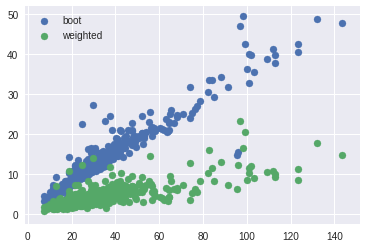

In [883]:
# This shows underprediction of errors :D ***KEEP***
plt.scatter(x,y,label="boot")
plt.scatter(x,z,label="weighted")
plt.legend()

In [884]:
# Likelihood
def lnlike(theta, x, y,yerr,ydel):
    m ,b,n,f,o,g = theta
    model = m * x +b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # model equation
    inv_sigma2 = 1.0/((yerr)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f,o,g = theta
    if -2 < m < 2 and -20 < b < 20 and  -1 < n < 1 and -10 < f < 10 and -10 < o < 10 and -10 < g < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr,ydel):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr,ydel)

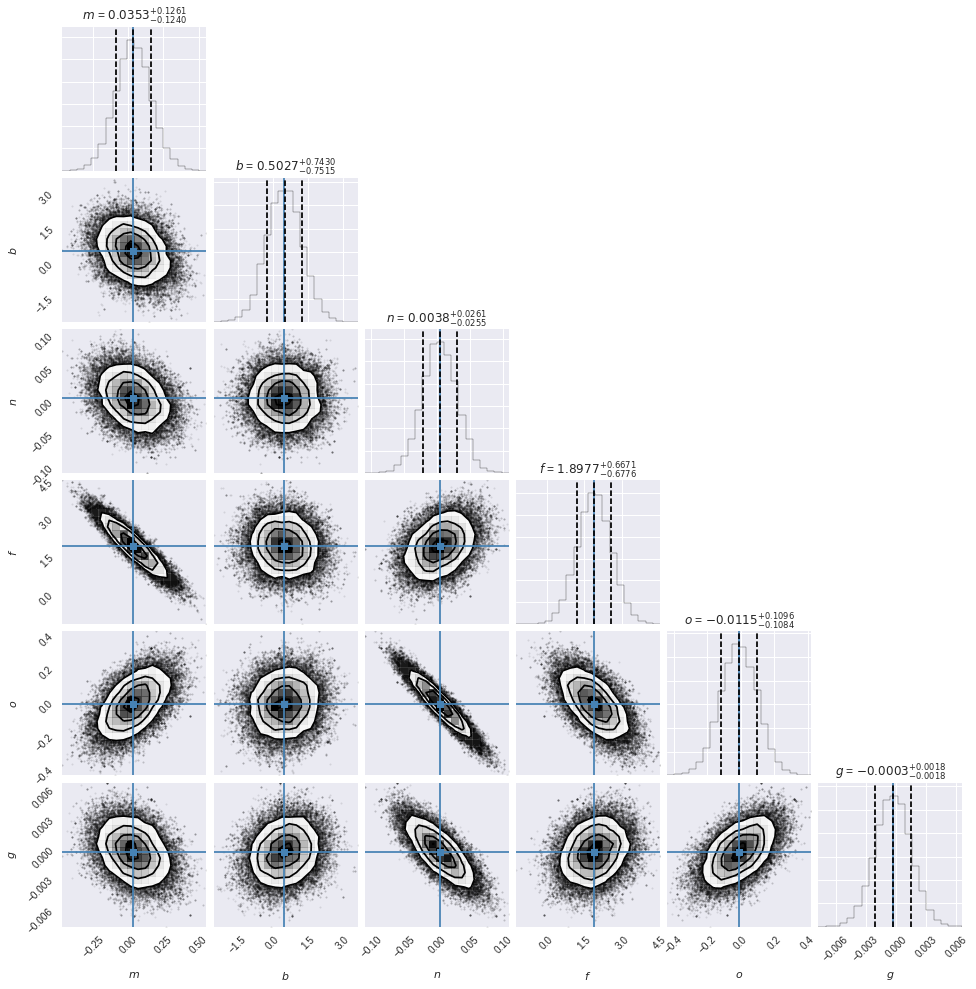

In [885]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
argum=(x, y,yerr,ydel)
result = op.minimize(nll, [1.]*6, args=argum)
m_ml, b_ml,n_ml,f_ml,o_ml,g_ml= result["x"]
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=argum) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$","$o$","$g$"],
                      truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

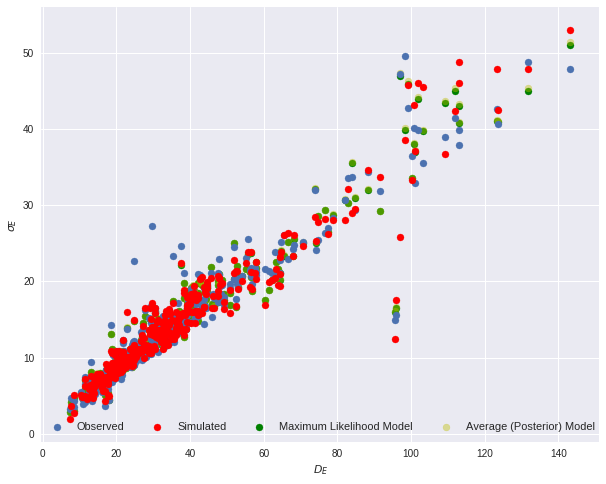

In [886]:
plt.figure(figsize=(10,8))

AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2
y_ml=m_ml*x+b_ml+n_ml*ydel*x+f_ml*ydel+o_ml*ydel**2+g_ml*x**2
y_me=meanest[0]*x+meanest[1]+meanest[2]*ydel*x+meanest[3]*ydel+meanest[4]*ydel**2+meanest[5]*x**2
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plobs = plt.scatter(x,y)
plsim = plt.scatter(x,y_sim,c='r')
#plt.scatter(x,w,c='k')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

Rejection rate (%): 0.018003240583304995
Bayesian p-value: 0.0839151047188


(0, 62.341684663331606)

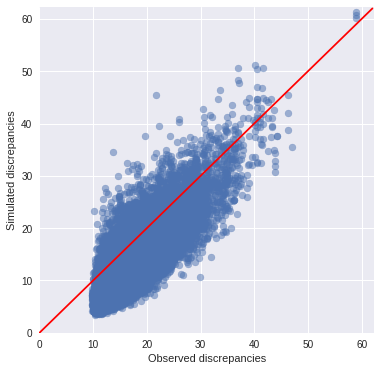

In [887]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
for m,b,n,f,o,g in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*ydel*x+AAA[:,3]*ydel+AAA[:,4]*ydel**2+AAA[:,5]*x**2 # create a synthetic dataset
    yexp=m*x+b+n*ydel*x+f*ydel+o*ydel**2+g*x**2 # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

### Resultados
- Cuando nmeas > 14 el p es bueno, pero para nmeas > 13 ya es malo. Guardar p, nmeas, ngal
- Con el minimo nmeas (14) no se logra independencia de sigma_sigma (sigma_sigma_indep.ipynb)
- Funciona para nmeas > 20 con modelo lineal y yerr = f*x y tambien para sigma_b=pol(x,3) y yerr cuadrático -> el great model se va dañando --> señal de que modelos más simples funcionan
- No funciona cuando yerr es función de y (igual que en sigma_sigma_indep) - codigo en ysigma_sigma_indep.ipynb
- No funciona cuando el peso se toma como 1/yerr y yerr es función de y (sysigma_sigma_indep.ipynb)
- No funciona cuando el peso se toma como 1/yerr y yerr es función de x (ssigma_sigma_indep.ipynb)
- MCMC falla para modelos polinomicos independientes con npol > 3 casi con cualquier yerr
- Para y=mx+b y yerr = wstd y w=1/(yerr^2+(f*y)^2)  no funciona el modelo independiente de sigma_sigma (para w=1/sqrt funciona aun peor)
- Para y=m*x+b+g*wstd y yerr = wstd o w=1/(yerr^2+(f*y)^2) o w=1/(yerr^2+(f*x)^2) no funciona, pero no esta mal tampoco (cerca) (para w=1/sqrt se aleja, parece ser en todos los casos) -> para nmeas > 19 obtenemos un buen p
- El modelo con yerr=wstd y w=1/yerr^2 funciona bien para predecir sigma_b. no es necesario añadir error en cuadratura para el peso estadistico. Quedarse con el. Esto propone que el error lo podemos calcular usando wstd como un estimador aun bajando nmeas (falta hacer esto) -> en la vida real nmeas es demasiado alto. Este modelo funciona muy muy bien si yerr = sigma_sigma, pero esa no es la idea (son demasiados inputs D_50, wstd, sigma_sigma). Sin embargo, no funciona mejor si sigma_sigma se usa para los pesos estadísticos pero no para el modelo. Quedarse con el modelo tal y como está
    - Se puede intentar trabajar con pocos parametros y nmeas > 19
- El modelo para sigma_b^2=(rand)^2+(syst)^2 no funciona ni con w por cuadratura. Pero MCMC da un resultado, del cual se podrían sacar valores.
    - El analisis por cuadratura con rand=Ax+B no funciona para nada. Predice valores del error sistematico imaginarios.
    - Funciona mejor si asumimos que rand=Ax directamente, con yerr=sigma_sigma y w=1/yerr los resultados son muy consistentes para 4<nmeas<19. No dudo que pase un test AD (falta hacer esto).
    - El mismo modelo para aproximacion sugerida por S. Torres no funciona bien (rand tiene valores negativos a veces), pero considerando que sin aproximar nos va bien, no lo considero necesario. El otro problema es que predice un error sistematico demasiado grande, que no sirve para D<50Mpc.
    - De los resultados voy a hacer un bootstrap sobre los valores predichos por diferentes nmeas, pero queda el problema que a veces es negativo. Argumentar mejor? Por ahora pienso no pesar cada resultado de cada mcmc para el bootstrap.

### Modelo predictivo independiente

Este modelo es independiente de sigma_sigma y usa wstd como uno de las variables independientes. Prefiero el que tiene solo tres parametros (es suficiente para predecir sigma_boot con D_50 y wstd para nmeas < 20 - hay que hacerlo), pero mantengo el otro por si al bajar nmeas tengo problemas.

Tal vez no se necesita el modelo con cuatro parámetros.

El modelo lineal de x vs yerr con w=1/sigma_sigma^2 funciona muy bien. Y se puede bajar hasta nmeas = 17, pero después no funciona. No funciona porque no hay cómo estimar bien sigma_sigma, no? Si reemplazo w=1/(x/5)^2 funciona, pero falla en nmeas = 14.

El MPI se puede bajar con los means de la PP hasta nmeas>17 pero ya empieza a fallar (sobrepredice... es eso un problema? de pronto no?)

Si se intenta bayesiano para estimar el wstd. No veo qué se gane. Ahí si sería imposible hacer predicciones. O será que se va suavizando también? No creo!

In [707]:
def discrlin(x,ydel,samplesli,figs=True):
    discobs=[]
    discsim=[]
    nrealiz=50000
    krej=0
    for m,b in samplesli[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
        AAA=samplesli[np.random.randint(len(samples), size=len(x))]
        y_sim=AAA[:,0]*x+AAA[:,1] # create a synthetic dataset
        yexp=m*x+b # calculate expected values from Theta_i
    # Calculate discrepancies using the Freeman-Tukey statistic
        check=((yexp<0)|(y_sim<0)).sum()
        if check == 0 :
            discobs.append(((np.sqrt(ydel)-np.sqrt(yexp))**2).sum())
            discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
        else:
            krej+=1
    discobs=np.asarray(discobs)
    discsim=np.asarray(discsim)
    pvalue=(discobs<discsim).sum()*1./len(discobs)
    if len(discsim)>0:
        rrate=krej*100./len(discsim)
    else:
        rrate=-9999
    if figs:
        print("Rejection rate (%):", rrate)
        print("Bayesian p-value:", pvalue)
        # the model sometimes predicts negative values for errors, such datasets are rejected:
        #print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
        plt.figure(figsize=(6,6))
        plt.scatter(discobs,discsim,alpha=0.5)
        dmax=np.max(np.hstack((discobs,discsim)))+1
        ppp=np.arange(dmax)
        plt.plot(ppp,ppp,c='r')
        plt.xlabel("Observed discrepancies")
        plt.ylabel("Simulated discrepancies")
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
    return pvalue,rrate

def mcmcdisclin(x,ydel,yerr2,figs=True):
    def lnlikelin(theta, x, ydel,yerr2):# modelo lineal (D,wstd) independiente de sigma_sigma
        m ,b = theta
        model = m * x + b
        inv_sigma2 = 1.0/(yerr2**2)
                          #+(g*x)**2)
        return -0.5*(np.sum((ydel-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
    def lnpriorlin(theta):
        m, b = theta
        if -2 < m < 2 and -20 < b < 20:
            return 0.0
        return -np.inf
    def lnproblin(theta, x, ydel,yerr2):
        lp = lnpriorlin(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlikelin(theta, x, ydel,yerr2)
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1., 1.], args=(x, ydel, yerr2))
    m_ml, b_ml = result["x"]  
    if figs:
        print(result["x"])
        xl = np.array([x.min(), x.max()])
        plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
        plt.errorbar(x,ydel,yerr=yerr2,fmt='.')
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, ydel,yerr2)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesli = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    # When needed, we use the mean of the posterior for each parameter
    # The mean is an unbiased estimator for the best values of the model parameters
    meanest=samplesli.mean(axis=0) 
    # 3. Corner plot! Shows the marginalized distribution for our parameter space
    if figs:
        fig = corner.corner(samplesli, labels=["$m$", "$b$"],truths=meanest, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
        print(meanest)
    pvalue,rrate=discrlin(x,ydel,samplesli,figs=figs)
    return meanest,samplesli,pvalue,rrate

In [708]:
def discr(xnew,ynew,yenew,samples,figs=True):
    discobs=[]
    discsim=[]
    nrealiz=50000
    krej=0
    for m,b,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
        AAA=samples[np.random.randint(len(samples), size=len(xnew))]
        y_sim=AAA[:,0]*xnew+AAA[:,1]+AAA[:,2]*yenew # create a synthetic dataset
        yexp=m*xnew+b+f*yenew # calculate expected values from Theta_i
    # Calculate discrepancies using the Freeman-Tukey statistic
        check=((yexp<0)|(y_sim<0)).sum()
        if check == 0 :
            discobs.append(((np.sqrt(ynew)-np.sqrt(yexp))**2).sum())
            discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
        else:
            krej+=1
    discobs=np.asarray(discobs)
    discsim=np.asarray(discsim)    
    pvalue=(discobs<discsim).sum()*1./len(discobs)
    if len(discsim)>0:
        rrate=krej*100./len(discsim)
    else:
        rrate=-9999
    if figs:
        print("Rejection rate (%):", rrate)
        print("Bayesian p-value:", pvalue)
        # the model sometimes predicts negative values for errors, such datasets are rejected:
        #print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
        plt.figure(figsize=(6,6))
        plt.scatter(discobs,discsim,alpha=0.5)
        dmax=np.max(np.hstack((discobs,discsim)))+1
        ppp=np.arange(dmax)
        plt.plot(ppp,ppp,c='r')
        plt.xlabel("Observed discrepancies")
        plt.ylabel("Simulated discrepancies")
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
    return pvalue,rrate

def mcmcdisc(x,y,ydel,yerr,figs=True):
    def lnlikelin(theta, x, y,ydel,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
        m ,b,f = theta
        model = m * x + b + f * ydel
        inv_sigma2 = 1.0/(yerr**2)
        return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
    def lnpriorlin(theta):
        m, b,f = theta
        if -2 < m < 2 and -20 < b < 20 and -20 < f < 20:
            return 0.0
        return -np.inf
    # Posterior probability
    def lnproblin(theta, x, y,ydel,yerr):
        lp = lnpriorlin(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlikelin(theta, x, y,ydel,yerr)
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*3, args=(x, y,ydel,yerr))
    m_ml, b_ml,f_ml = result["x"]
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,ydel,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    # When needed, we use the mean of the posterior for each parameter
    # The mean is an unbiased estimator for the best values of the model parameters
    meanestbm=samples.mean(axis=0) 
    # 3. Corner plot! Shows the marginalized distribution for our parameter space
    if figs :
        print(result["x"])
        fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=meanestbm, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
        print(meanestbm)
    pvalue,rrate=discr(x,y,yerr,samples,figs=figs)    
    return meanestbm,samples,pvalue,rrate


In [650]:
filt=np.array(em)>19
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(wstd)[filt] # wstd

52


In [685]:
meannew,samples,pvalue,rrate=mcmcdisc(x,y,yerr,yerr,False)
print(pvalue,rrate)

0.70036 0.0


In [654]:
#A partir de aqui x= x pero y=wstd y yerr= sigma_sigma
ydel=np.array(wstd)[filt]
yerr2=np.array(bootsig)[filt] # sigma_sigma

In [656]:
meanestli,samplesli,pvalue,rrate=mcmcdisclin(x,ydel,yerr2,False)
print(pvalue,rrate)

0.134066959269 6.015308610563365


In [580]:
meanestli,samplesli=mcmcdisclin(x,ydel,x/5,False) # try not to use this

[ 0.1001656   1.20085163]
Rejection rate (%): 12.574580659687042
Bayesian p-value: 0.309985365305


In [ ]:
# this only uses the original ok model for predicting wstd and works amazing
# below nmeas < 17 bayesian p for wstd pred model gets wack (->1). maybe that's ok???
# somehow I'm not ok with this, the wstd model should also evolve but:
# if it's independent, then it will be even worse because ... I whould try but it probs wouldn't work?
# if it's dependent on sigma_sigma I think it won't work or it will stop working at some point (high nmeas)
# the bayesian p for wstd pred model using sigma_sigma for weight is also wack (-> 0) at nmeas = 18
# crazy thing is the normal mcmc holds... weird
# the latter gives more trust to the data

In [762]:
# using wstd predicting model using sigma_sigma and mcmc folding along the main mcmc folding
meanestbm=meannew
samplesbm=samples
samplin=samplesli
meanest=meanestli
xnew=x
ynew=y
yenew=yerr
ysnew=yerr2
def pcheck(pvalue,rrate,thing,over=False):    
    if pvalue > 0.975 or pvalue < 0.025 or over:
        print('*************')
        print(thing,': pvalue =',pvalue,'rrate =',rrate)
for nm in range(20)[::-1][:-1]:
    thisfilt=(np.array(em)==nm)
    xf=np.array(dboot)[thisfilt]
    ydp=meanest[0]*xf+meanest[1] # predicted wstd
    ypred=meanestbm[0]*xf+meanestbm[1]+meanestbm[2]*ydp # predicted sigma_B
    xnew=np.hstack((xnew,xf))
    ynew=np.hstack((ynew,ypred))
    yenew=np.hstack((yenew,ydp))
    ysnew=np.hstack((ysnew,np.array(bootsig)[thisfilt]))
    print('Dataset size =',len(xnew),'Nmeas =',nm)
    pvalue,rrate=discr(xnew,ynew,yenew,samplesbm,False)
    pcheck(pvalue,rrate,'Disc')
    meanestbm,samplesbm,pvalue,rrate=mcmcdisc(xnew,ynew,yenew,yenew,False)
    pcheck(pvalue,rrate,'MCMC')
    pvalue,rrate=discrlin(xnew,yenew,samplin,False)
    pcheck(pvalue,rrate,'Disc lin')
    meanest,samplin,pvalue,rrate=mcmcdisclin(xnew,yenew,ysnew,False)
    pcheck(pvalue,rrate,'MCMC lin')
    print('*************')
xwss=xnew
ywss=ynew
yewss=yenew
mnwss=meanestbm

Dataset size = 89 Nmeas = 19
*************
Dataset size = 126 Nmeas = 18
*************
MCMC lin : pvalue = 0.0202064660691 rrate = 0.03201024327784891
*************
Dataset size = 181 Nmeas = 17
*************
MCMC lin : pvalue = 0.0228418273462 rrate = 0.008000640051204096
*************
Dataset size = 240 Nmeas = 16
*************
MCMC lin : pvalue = 0.0067 rrate = 0.0
*************
Dataset size = 337 Nmeas = 15
*************
MCMC lin : pvalue = 0.00872 rrate = 0.0
*************
Dataset size = 452 Nmeas = 14
*************
MCMC lin : pvalue = 0.0028 rrate = 0.0
*************
Dataset size = 675 Nmeas = 13
*************
MCMC lin : pvalue = 0.01176 rrate = 0.0
*************
Dataset size = 930 Nmeas = 12
*************
Dataset size = 1153 Nmeas = 11
*************
MCMC lin : pvalue = 0.01678 rrate = 0.0
*************
Dataset size = 1396 Nmeas = 10
*************
MCMC lin : pvalue = 0.00558 rrate = 0.0
*************
Dataset size = 1730 Nmeas = 9
*************
Dataset size = 2182 Nmeas = 8
******

In [709]:
meanestbm=meannew
samplesbm=samples
samplin=samplesli
meanest=meanestli
xnew=x
ynew=y
yenew=yerr
ysnew=yerr2
def pcheck(pvalue,rrate,thing,over=False):    
    if pvalue > 0.975 or pvalue < 0.025 or over:
        print('*************')
        print(thing,': pvalue =',pvalue,'rrate =',rrate)
for nm in range(20)[::-1][:-5]:
    thisfilt=(np.array(em)==nm)
    xf=np.array(dboot)[thisfilt]
    ydp=meanest[0]*xf+meanest[1] # predicted wstd
    ypred=meanestbm[0]*xf+meanestbm[1]+meanestbm[2]*ydp # predicted sigma_B
    xnew=np.hstack((xnew,xf))
    ynew=np.hstack((ynew,ypred))
    yenew=np.hstack((yenew,ydp))
    ysnew=np.hstack((ysnew,np.array(bootsig)[thisfilt]))
    print('Dataset size =',len(xnew),'Nmeas =',nm)
    pvalue,rrate=discr(xnew,ynew,yenew,samplesbm,False)
    pcheck(pvalue,rrate,'Disc')
    meanestbm,samplesbm,pvalue,rrate=mcmcdisc(xnew,ynew,yenew,yenew,False)
    pcheck(pvalue,rrate,'MCMC')
    pvalue,rrate=discrlin(xnew,yenew,samplin,False)
    pcheck(pvalue,rrate,'Disc lin')
#    meanest,samplin,pvalue,rrate=mcmcdisclin(xnew,yenew,ysnew,False)
#    pcheck(pvalue,rrate,'MCMC lin')
    print('*************')
xnf=xnew
ynf=ynew
yenf=yenew
mnnf=meanestbm

Dataset size = 89 Nmeas = 19
*************
Dataset size = 126 Nmeas = 18
*************
Dataset size = 181 Nmeas = 17
*************
Dataset size = 240 Nmeas = 16
*************
Disc lin : pvalue = 0.981667343505 rrate = 45.036839357196726
*************
Dataset size = 337 Nmeas = 15
*************
Disc lin : pvalue = 0.9936690555 rrate = 60.68387055307388
*************
Dataset size = 452 Nmeas = 14
*************
Disc lin : pvalue = 0.997243586894 rrate = 122.29137954030142
*************
Dataset size = 675 Nmeas = 13
*************
Disc : pvalue = 0.9771 rrate = 0.0
*************
Disc lin : pvalue = 0.99979868474 rrate = 235.52543282780834
*************
Dataset size = 930 Nmeas = 12
*************
Disc lin : pvalue = 0.99960254372 rrate = 562.4271330153683
*************
Dataset size = 1153 Nmeas = 11
*************
Disc lin : pvalue = 1.0 rrate = 1105.400192864031
*************
Dataset size = 1396 Nmeas = 10
*************
Disc lin : pvalue = 1.0 rrate = 2162.443438914027
*************
Dataset 

In [710]:
# shitty x/5 folding wst model
meanestbm=meannew
samplesbm=samples
samplin=samplesli
meanest=meanestli
xnew=x
ynew=y
yenew=yerr
ysnew=yerr2
def pcheck(pvalue,rrate,thing,over=False):    
    if pvalue > 0.975 or pvalue < 0.025 or over:
        print('*************')
        print(thing,': pvalue =',pvalue,'rrate =',rrate)
for nm in range(20)[::-1][:-5]:
    thisfilt=(np.array(em)==nm)
    xf=np.array(dboot)[thisfilt]
    ydp=meanest[0]*xf+meanest[1] # predicted wstd
    ypred=meanestbm[0]*xf+meanestbm[1]+meanestbm[2]*ydp # predicted sigma_B
    xnew=np.hstack((xnew,xf))
    ynew=np.hstack((ynew,ypred))
    yenew=np.hstack((yenew,ydp))
    ysnew=np.hstack((ysnew,np.array(bootsig)[thisfilt]))
    print('Dataset size =',len(xnew),'Nmeas =',nm)
    pvalue,rrate=discr(xnew,ynew,yenew,samplesbm,False)
    pcheck(pvalue,rrate,'Disc')
    meanestbm,samplesbm,pvalue,rrate=mcmcdisc(xnew,ynew,yenew,yenew,False)
    pcheck(pvalue,rrate,'MCMC')
    pvalue,rrate=discrlin(xnew,yenew,samplin,False)
    pcheck(pvalue,rrate,'Disc lin')
    meanest,samplin,pvalue,rrate=mcmcdisclin(xnew,yenew,xnew/5,False)
    pcheck(pvalue,rrate,'MCMC lin')
    print('*************')
xsf=xnew
ysf=ynew
yesf=yenew
mnsf=meanestbm

Dataset size = 89 Nmeas = 19
*************
Dataset size = 126 Nmeas = 18
*************
Dataset size = 181 Nmeas = 17
*************
Dataset size = 240 Nmeas = 16
*************
Dataset size = 337 Nmeas = 15
*************
Dataset size = 452 Nmeas = 14
*************
MCMC lin : pvalue = 0.00992 rrate = 0.0
*************
Dataset size = 675 Nmeas = 13
*************
Disc : pvalue = 0.97954 rrate = 0.0
*************
MCMC lin : pvalue = 0.00652 rrate = 0.0
*************
Dataset size = 930 Nmeas = 12
*************
Disc : pvalue = 0.97804 rrate = 0.0
*************
MCMC lin : pvalue = 0.00708 rrate = 0.0
*************
Dataset size = 1153 Nmeas = 11
*************
MCMC lin : pvalue = 0.00508 rrate = 0.0
*************
Dataset size = 1396 Nmeas = 10
*************
MCMC lin : pvalue = 0.0055 rrate = 0.0
*************
Dataset size = 1730 Nmeas = 9
*************
MCMC lin : pvalue = 0.01568 rrate = 0.0
*************
Dataset size = 2182 Nmeas = 8
*************
MCMC lin : pvalue = 2e-05 rrate = 0.0
**********

In [711]:
afilt=np.array(em)>4
print(afilt.sum())
ax=np.array(dboot)[afilt]
ay=np.array(bootp50)[afilt]
ayerr=np.array(wstd)[afilt]

3729


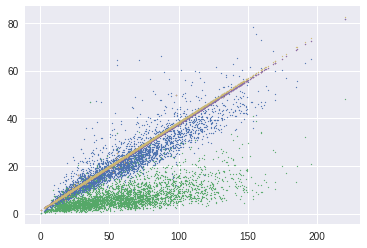

In [758]:
plt.scatter(ax,ay,s=1)
plt.scatter(ax,ayerr,s=1)
plt.scatter(xwss,ywss,s=1)
plt.scatter(xnf,ynf,s=1)
plt.scatter(xsf,ysf,s=1)


(8, 8.7)

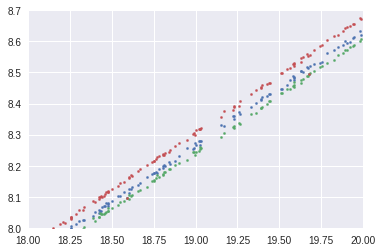

In [737]:
plt.scatter(xwss,ywss,s=5)
plt.scatter(xnf,ynf,s=5)
plt.scatter(xsf,ysf,s=5)
plt.xlim(18,20)# using sigma_sigma
plt.ylim(8,8.7)

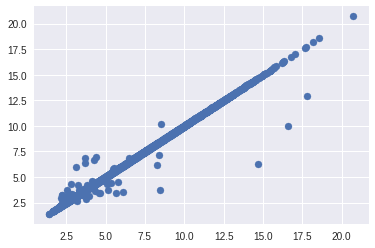

In [739]:
plt.scatter(yewss,meanestli[0]*xwss+meanestli[1])

(8, 8.7)

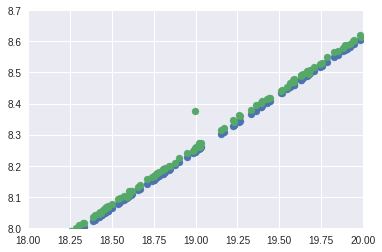

In [743]:
plt.scatter(xwss,xwss*meannew[0]+meannew[1]+meannew[2]*(meanestli[0]*xwss+meanestli[1]))
plt.scatter(xwss,xwss*meanestbm[0]+meanestbm[1]+meanestbm[2]*yewss)
#plt.scatter(xwss,ywss)
plt.xlim(18,20)# using sigma_sigma
plt.ylim(8,8.7)


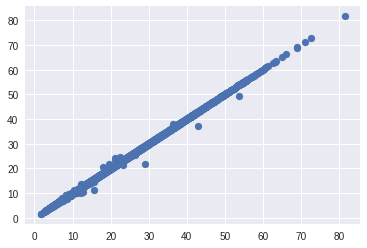

In [745]:
plt.scatter(xwss*meanestbm[0]+meanestbm[1]+meanestbm[2]*yewss,xwss*meannew[0]+meannew[1]+meannew[2]*(meanestli[0]*xwss+meanestli[1]))

In [746]:
yean=meanestli[0]*xwss+meanestli[1]

[ 0.32036289  0.67144193  0.50212799]
[ 0.23976513 -0.55487054  1.41746723]
Rejection rate (%): 0.0
Bayesian p-value: 0.0


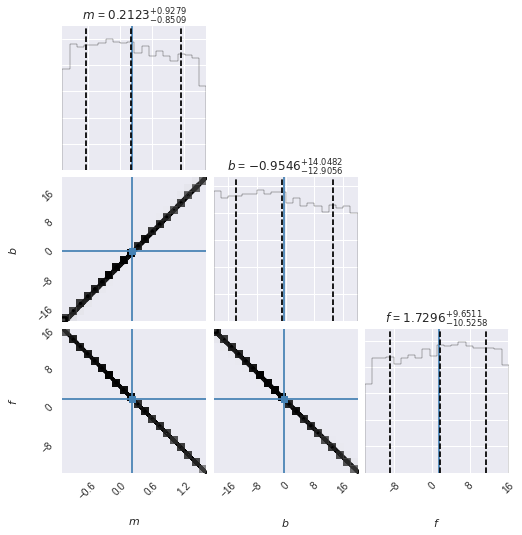

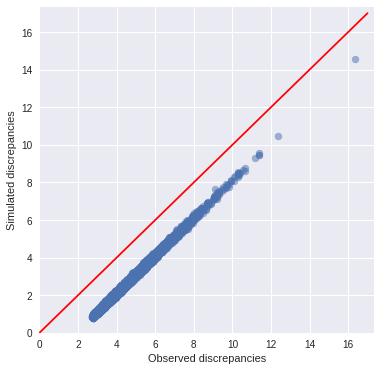

In [750]:
mn,sb,pvalue,rrate=mcmcdisc(xwss,ywss,yean,yean,True)

[ 0.28694788  0.15410398  0.88046907]
[ 0.28512372  0.13227463  0.89955961]
Rejection rate (%): 0.0
Bayesian p-value: 0.87796


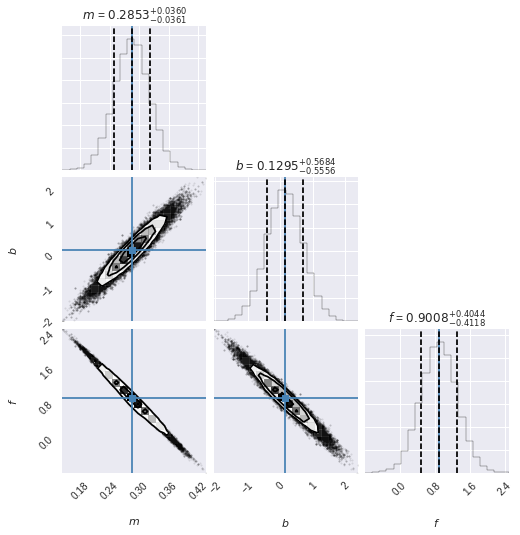

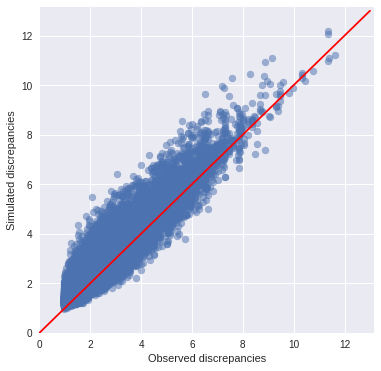

In [749]:
mn,sb,pvalue,rrate=mcmcdisc(xwss,ywss,yewss,yewss,True)

In [752]:
yeannf=meanestli[0]*xnf+meanestli[1]

[ 0.32135541  0.66309335  0.49114372]
[ 0.28302938  0.07947138  0.92671553]
Rejection rate (%): 0.0
Bayesian p-value: 0.0


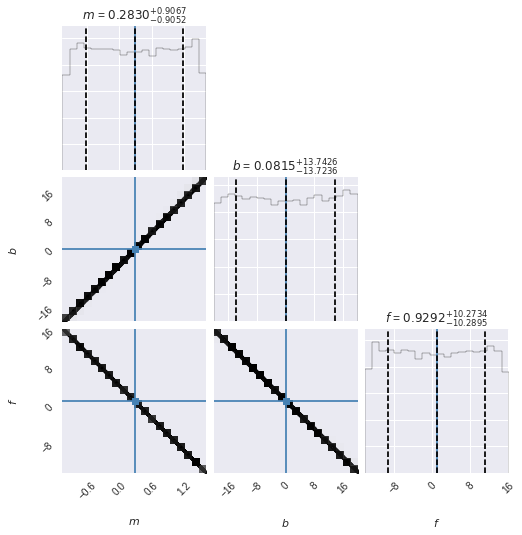

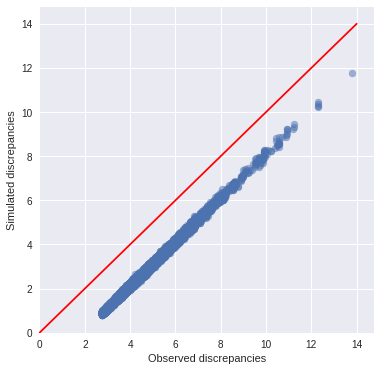

In [753]:
mn,sb,pvalue,rrate=mcmcdisc(xnf,ynf,yeannf,yeannf,True)

[ 0.28731499  0.1454015   0.87714145]
[ 0.28754924  0.14633354  0.87539002]
Rejection rate (%): 0.0
Bayesian p-value: 0.90028


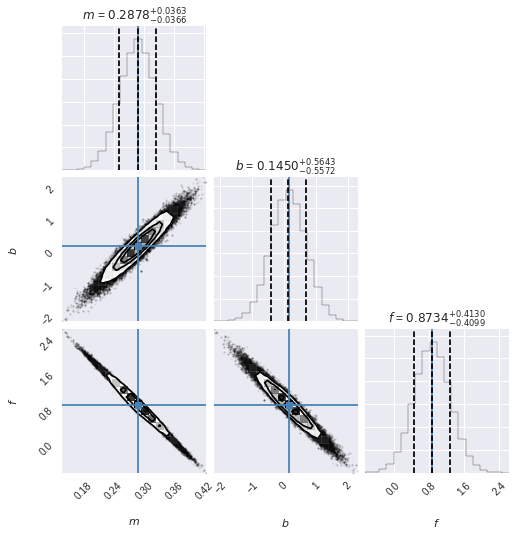

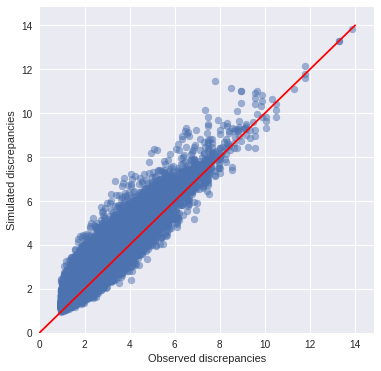

In [754]:
mn,sb,pvalue,rrate=mcmcdisc(xnf,ynf,yenf,yenf,True)

In [755]:
yeansf=meanestli[0]*xsf+meanestli[1]

[ 0.32835742  0.64856096  0.47189392]
[ 0.29372891  0.1220607   0.8654257 ]
Rejection rate (%): 0.0
Bayesian p-value: 0.0


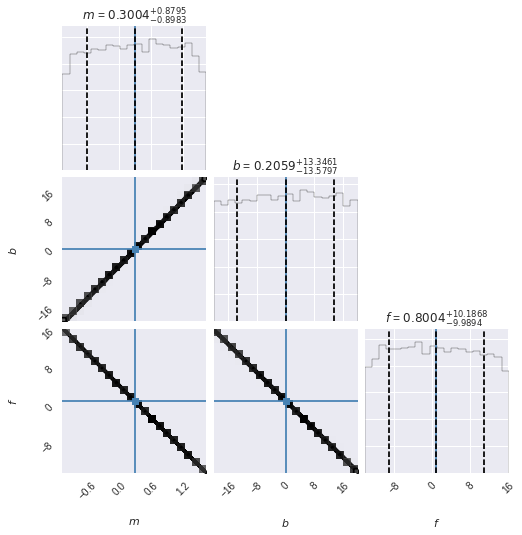

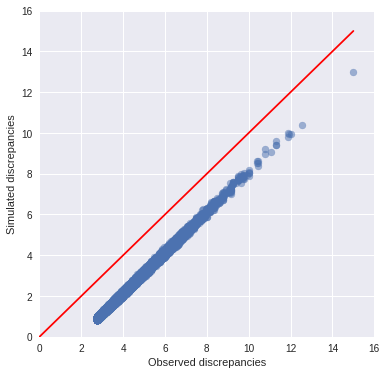

In [756]:
mn,sb,pvalue,rrate=mcmcdisc(xsf,ysf,yeansf,yeansf,True)

[ 0.28715431  0.1479878   0.87949129]
[ 0.28763566  0.1596488   0.87365458]
Rejection rate (%): 0.0
Bayesian p-value: 0.91452


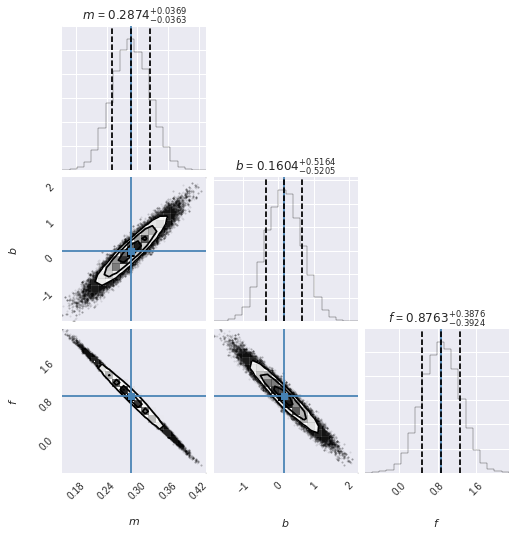

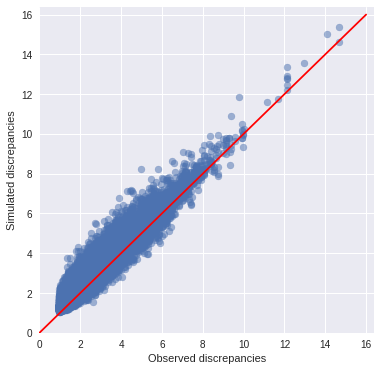

In [757]:
mn,sb,pvalue,rrate=mcmcdisc(xsf,ysf,yesf,yesf,True)

In [ ]:
afilt=np.array(em)>4
print(afilt.sum())
ax=np.array(dboot)[afilt]
ay=np.array(bootp50)[afilt]
ayerr=np.array(wstd)[afilt]

(0, 140)

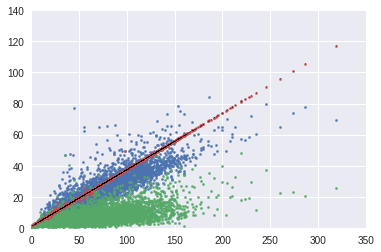

In [774]:
plt.scatter(np.array(dboot),np.array(bootp50),s=5)
plt.scatter(np.array(dboot),np.array(wstd),s=5)
plt.scatter(xwss,ywss,s=5)
plt.scatter(xwss,xwss*meannew[0]+meannew[1]+meannew[2]*(meanestli[0]*xwss+meanestli[1]),s=0.1,c='k')
plt.xlim(0,350)# using sigma_sigma
plt.ylim(0,140)

In [ ]:
# how about a model that's just like four parameters and that's that?

(0, 140)

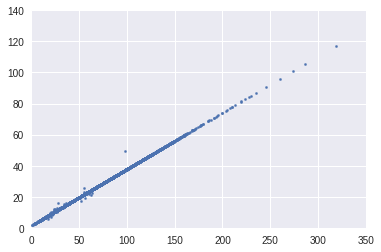

In [769]:
plt.scatter(xwss,ywss,s=5)
plt.xlim(0,350)# using sigma_sigma
plt.ylim(0,140)

In [770]:
meanestli

array([ 0.0881205 ,  1.33575156])

In [771]:
meanestbm

array([ 0.28731816,  0.15903416,  0.87470467])

In [795]:
def discrs(xnew,ynew,samples,figs=True):
    discobs=[]
    discsim=[]
    nrealiz=50000
    krej=0
    for m,b in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
        AAA=samples[np.random.randint(len(samples), size=len(xnew))]
        y_sim=AAA[:,0]*xnew+AAA[:,1] # create a synthetic dataset
        yexp=m*xnew+b # calculate expected values from Theta_i
    # Calculate discrepancies using the Freeman-Tukey statistic
        check=((yexp<0)|(y_sim<0)).sum()
        if check == 0 :
            discobs.append(((np.sqrt(ynew)-np.sqrt(yexp))**2).sum())
            discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
        else:
            krej+=1
    discobs=np.asarray(discobs)
    discsim=np.asarray(discsim)    
    pvalue=(discobs<discsim).sum()*1./len(discobs)
    if len(discsim)>0:
        rrate=krej*100./len(discsim)
    else:
        rrate=-9999
    if figs:
        print("Rejection rate (%):", rrate)
        print("Bayesian p-value:", pvalue)
        # the model sometimes predicts negative values for errors, such datasets are rejected:
        #print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
        plt.figure(figsize=(6,6))
        plt.scatter(discobs,discsim,alpha=0.5)
        dmax=np.max(np.hstack((discobs,discsim)))+1
        ppp=np.arange(dmax)
        plt.plot(ppp,ppp,c='r')
        plt.xlabel("Observed discrepancies")
        plt.ylabel("Simulated discrepancies")
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
    return pvalue,rrate

def mcmcdiscs(x,y,figs=True):
    def lnlikelin(theta, x, y):
        m ,b = theta
        model = m * x + b
        yerr = x
        inv_sigma2 = 1.0/(yerr**2)
        return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
    def lnpriorlin(theta):
        m, b = theta
        if -2 < m < 2 and -20 < b < 20:
            return 0.0
        return -np.inf
    # Posterior probability
    def lnproblin(theta, x, y):
        lp = lnpriorlin(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlikelin(theta, x, y)
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*2, args=(x, y))
    m_ml, b_ml = result["x"]
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 10000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    # When needed, we use the mean of the posterior for each parameter
    # The mean is an unbiased estimator for the best values of the model parameters
    meanestbm=samples.mean(axis=0) 
    # 3. Corner plot! Shows the marginalized distribution for our parameter space
    if figs :
        print(result["x"])
        fig = corner.corner(samples, labels=["$m$", "$b$"],truths=meanestbm, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
        print(meanestbm)
    pvalue,rrate=discrs(x,y,samples,figs=figs)    
    return meanestbm,samples,pvalue,rrate


[  0.35411114   1.4335859  -12.96175958]
[  0.47004243  -0.82836439 -19.21433238]
Rejection rate (%): 0.03201024327784891
Bayesian p-value: 0.576124359795


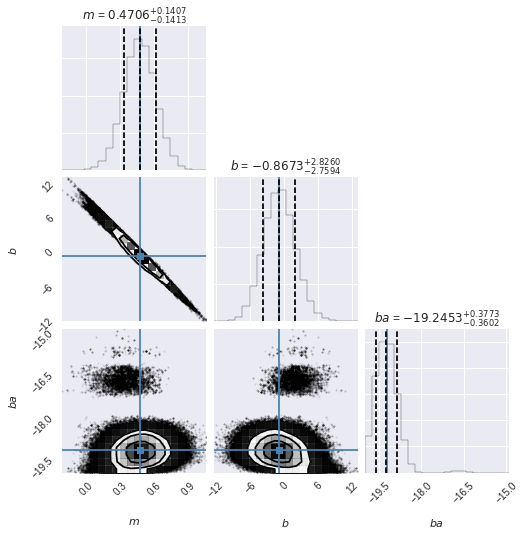

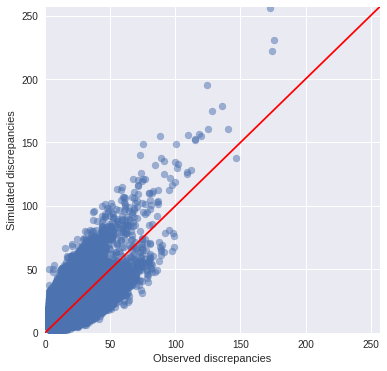

In [790]:
mn,sb,pvalue,rrate=mcmcdiscs(x,y,True)
# este modelo de tres parámetros parece funcionar bien, p = 0.6
# no sirve el modelo de dos parametros en el que el peso es 1/x^2. p = 0.98


[ 0.37702166  1.12893155]
[ 0.38105418  1.01146152]
Rejection rate (%): 199.2399305763361
Bayesian p-value: 0.984559219582


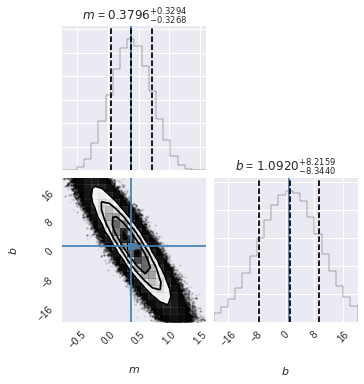

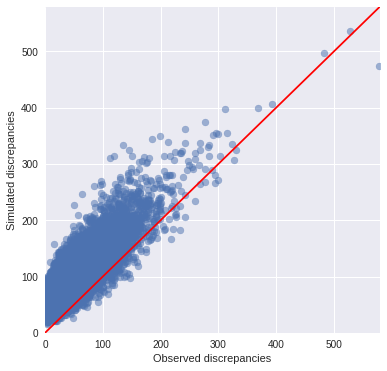

In [796]:
mn,sb,pvalue,rrate=mcmcdiscs(x,y,True) 

### Modelo de errores por cuadratura

Este modelo simple produce para distintos nmeas un valor consistente para el error sistematico de entre 3.7 y 6.1 Mpc. No reproduce la varianza pero produce una posterior predictive que posiblemente pase un test AD (hay que hacerlo). Si no lo pasa, intentar con peso estadistico por cuadratura, pero no creo que sea necesario.

In [13]:
def lnlikelin(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b = theta
    model = m * x**2 + b**2
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b = theta
    if 0 < m < 10 and 0 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [188]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(5,19): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
    #yerr=yerr**2
    nll = lambda *args: -lnlikelin(*args)
    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    m_ml, b_ml = result["x"]
    if b_ml > 0:
        print(i,result["x"])
        ndim, nwalkers = len(result["x"]), 100
        pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
        # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
        sampler.run_mcmc(pos, 1000);
        # Here we remove the burn-in steps, which we estimate to be around 100. 
        # This can be estimated by calculating the autocorrelation time (see below)
        samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
        bdist=np.hstack((bdist,samples[:,1]))
        mdist=np.hstack((mdist,samples[:,0]))
        coun+=1

5 [ 0.11448708  3.7338556 ]
7 [ 0.12061383  4.16619464]
8 [ 0.11995081  5.03419613]
9 [ 0.12167945  4.766928  ]
10 [ 0.12346205  4.78521634]
11 [ 0.12618868  4.63015754]
12 [ 0.12433152  4.68330603]
13 [ 0.1177356   4.94774974]
14 [ 0.11468093  5.28881818]
15 [ 0.10713032  5.49321789]
16 [ 0.10227988  5.77763872]
17 [ 0.09626689  6.17027706]
18 [ 0.10862491  5.79443819]


In [189]:
delt=int(len(bdist)/coun)
titer=1000
bal=[]
bm=[]
bp=[]
for i in range(titer):
    foo=[]
    for ri in range(coun-1):
        foo += [random.choice(bdist[ri*delt:(ri+1)*delt])]
    bal+=[np.mean(foo)]
    bm+=[np.percentile(foo, 50)-np.percentile(foo, 16)]
    bp+=[np.percentile(foo, 84)-np.percentile(foo, 50)]

In [190]:
ro=2
minus=str(np.around(np.mean(bm),ro))
plus=str(np.around(np.mean(bp),ro))
mmean=str(np.around(np.mean(bal),ro))
print('Distance systematic error is',mmean,'minus',minus,'plus',plus)

Distance systematic error is 4.96 minus 0.35 plus 0.69


In [200]:
#relative errors in mmean, minus, plus
print(np.std(bm)*100/np.mean(bm),np.std(bp)*100/np.mean(bp),np.std(bal)*100/np.mean(bal))
# looks very good

6.42557262824 3.80813014146 0.134842992519


In [ ]:
# falta generar ysims para hacer un test AD, toca uno por cada mcmc para estar tranquilos
# tambien es necesario usar el modelo independiente de sigma_sigma
# la idea es poder predecir sigma_b con el modelo que sale de MCMC para menores nmeas (uno por uno)
# con eso actualizar sigma_b y volver a probar el mcmc hasta que falle o algo?

# para que sirve el great model? -> el problema es sigma_sigma, que en general es desconocido
# podriamos aplicar algo de esto a otros metodos? por lo menos la ultima parte si se puede intentar
# habria que volver a hacer todos los intentos (si de primera no funciona)

Rejection rate (%): 0.0
Bayesian p-value: 0.0


(0, 44.324272584795715)

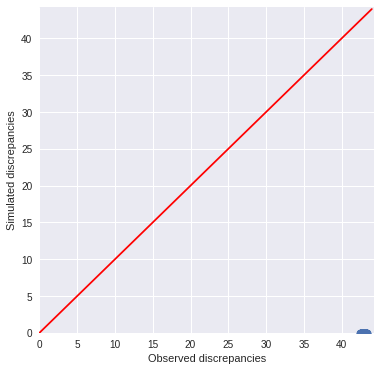

In [847]:
discobs=[]
discsim=[]
nrealiz=50000
krej=0
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
for m,b in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=np.sqrt(AAA[:,0]*x**2+AAA[:,1]**2) # create a synthetic dataset
    yexp=np.sqrt(m*x**2+b**2) # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    check=((yexp<0)|(y_sim<0)|np.isnan(yexp)|np.isnan(y_sim)).sum()
    if check == 0 :
        discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
        discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
    else:
        krej+=1
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
print("Rejection rate (%):", krej*100./len(discsim))
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim,alpha=0.5)
print("Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs))
# the model sometimes predicts negative values for errors, such datasets are rejected:
#print("Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim))
dmax=np.max(np.hstack((discobs,discsim)))+1
ppp=np.arange(dmax)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,dmax)
plt.ylim(0,dmax)

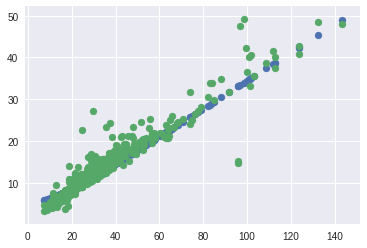

In [848]:
plt.scatter(x,y_sim)
plt.scatter(x,y)

### Anderson-Darling

Pruebas

In [189]:
k=0
myr=1000
for i in range(myr):
    p1=np.sort(np.random.normal(2.01,0.2,1000))
    p2=np.sort(np.random.normal(2,0.2,1000))
    p3=np.sort(np.random.normal(2,0.2,1000))
    ksan=ss.anderson_ksamp([p1,p2,p3])
    if ksan.statistic > ksan.significance_level:
        k+=1
k/myr

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


0.536

In [190]:
ss.anderson_ksamp([p1,p2,p3])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=-0.1686782783093777, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=0.4839994150713497)

(array([   3.,    4.,   26.,   81.,  185.,  256.,  244.,  130.,   56.,   15.]),
 array([ 1.23908141,  1.37235938,  1.50563735,  1.63891533,  1.7721933 ,
         1.90547127,  2.03874925,  2.17202722,  2.3053052 ,  2.43858317,
         2.57186114]),
 <a list of 10 Patch objects>)

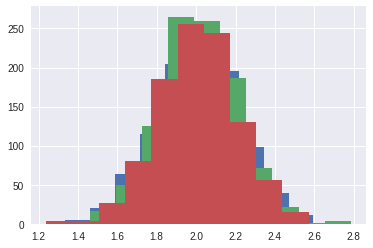

In [191]:
plt.hist(p1)
plt.hist(p2)
plt.hist(p3)

In [192]:
ss.anderson_ksamp([y,y_sim,yexp])

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=7.7176953726283273, critical_values=array([ 0.44925884,  1.3052767 ,  1.9434184 ,  2.57696569,  3.41634856]), significance_level=7.971553219922106e-05)

If A2 is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected.